# GATE Compton: find events

In [1]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
import plotly
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import math
import awkward as ak

from scipy.optimize import curve_fit
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import UnivariateSpline


## Parameters

In [2]:
ERES = 0.005  # Energy resolution in MeV
PRES = 0.5    # Position resolution in mm

NHEADS = 10
HEAD_DIRECTION_MAP = {i: [-math.sin(2 * math.pi * i / NHEADS), -math.cos(2 * math.pi * i / NHEADS), 0] for i in range(10)}

HEAD_DIRECTION_MAP

{0: [-0.0, -1.0, 0],
 1: [-0.5877852522924731, -0.8090169943749475, 0],
 2: [-0.9510565162951535, -0.30901699437494745, 0],
 3: [-0.9510565162951536, 0.30901699437494734, 0],
 4: [-0.5877852522924732, 0.8090169943749473, 0],
 5: [-1.2246467991473532e-16, 1.0, 0],
 6: [0.587785252292473, 0.8090169943749475, 0],
 7: [0.9510565162951535, 0.30901699437494756, 0],
 8: [0.9510565162951536, -0.30901699437494723, 0],
 9: [0.5877852522924732, -0.8090169943749473, 0]}

## Datasets

In [3]:
#Two point sources for spatial resolution
# filename = '/Users/jcaravaca/Work_Local/data_overflow/C4/gate/results/C4_10heads_twopointsources_141keV_10kBq_30mm_60s.root'
filename = '/Users/jcaravaca/Work_Local/data_overflow/C4/gate/results/C4_10heads_twopointsources_141keV_10kBq_30mm_600s.root'

## Find SPECT events

In [4]:
def find_spect_events(gate_file, e_lo, e_hi, debug=True):
    
    f = uproot.open(gate_file)
    df_singles = f['Singles'].arrays()
    df_singles = ak.to_dataframe( df_singles )

    # Energy resolution
    df_singles['energy'] = np.random.normal(df_singles['energy'].astype(float), ERES)

    # Position resolution
    df_singles['globalPosX'] = np.random.normal(df_singles['globalPosX'].astype(float), PRES)
    df_singles['globalPosY'] = np.random.normal(df_singles['globalPosY'].astype(float), PRES)
    df_singles['globalPosZ'] = np.random.normal(df_singles['globalPosZ'].astype(float), PRES)

    # Get events with only 1 single
    df_singles_gbID = df_singles.groupby('eventID')
    df_singles_1hit = df_singles_gbID.filter(lambda x: x['energy'].count()==1)
    df_singles_1hit_gbID =  df_singles_1hit.groupby('eventID')
    if debug:
        nhits_bf = df_singles_gbID['energy'].count()
        nhits_af = df_singles_1hit_gbID['energy'].count()
        plt.hist(nhits_bf,bins=10,range=(0,10))
        plt.hist(nhits_af,bins=10,range=(0,10))
        plt.show()
    
    # Get events with energy within photopeak
    df_singles_1hit_pp = df_singles_1hit_gbID.filter(lambda x: (x['energy'].sum()>e_lo) & (x['energy'].sum()<e_hi) )
    df_singles_1hit_pp_bgID = df_singles_1hit_pp.groupby('eventID')
    if debug:
        energy_total_bf = df_singles_1hit_gbID['energy'].sum()
        energy_total_af = df_singles_1hit_pp_bgID['energy'].sum()
        plt.hist(energy_total_bf,bins=100,range=(0,1.))
        plt.hist(energy_total_af,bins=100,range=(0,1.))
        plt.show()

    return df_singles_1hit_pp


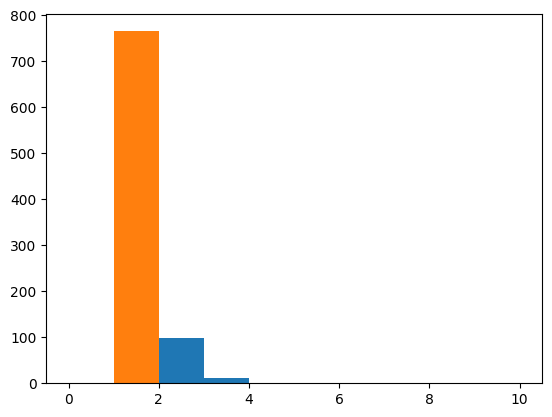

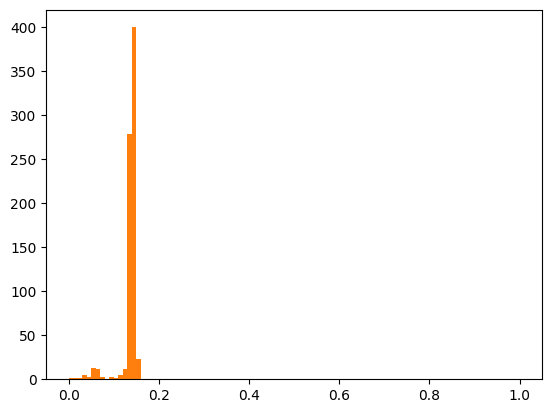

In [5]:
df_spects = find_spect_events(filename,0.0, 9999.)

In [6]:
df_spects

,runID,eventID,sourceID,sourcePosX,sourcePosY,sourcePosZ,time,energy,globalPosX,globalPosY,...,unused4ID,unused5ID,comptonPhantom,comptonCrystal,RayleighPhantom,RayleighCrystal,axialPos,rotationAngle,comptVolName,RayleighVolName
entry,,,,,,,,,,,,,,,,,,,,,
0,0,4150,0,-14.620114,125.074287,0.094031,0.203221,0.142771,-9.356853,-231.619066,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL
1,0,17113,0,-15.234099,125.357681,-0.014723,0.842928,0.136461,-17.269942,236.042699,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL
4,0,87249,1,15.028153,125.353935,0.231774,4.351294,0.146803,14.575853,234.128555,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL
5,0,139638,1,15.119330,125.173874,-0.072324,6.985551,0.144908,14.013212,-233.858743,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL
6,0,152159,1,15.304585,124.792221,-0.240014,7.609255,0.143542,7.095099,-232.768082,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,1138692,0,-15.109259,125.018326,-0.227161,57.006469,0.133853,-17.424619,239.421908,...,-1,-1,0,0,0,1,0.0,0.0,NULL,NULL
995,0,1146423,0,-15.056284,125.021591,-0.069220,57.388633,0.137128,-15.544873,239.864553,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL
996,0,1147555,0,-14.845676,124.700180,0.170605,57.447148,0.143905,-15.675072,233.619695,...,-1,-1,0,0,0,0,0.0,0.0,NULL,NULL


## Plot energy distributions

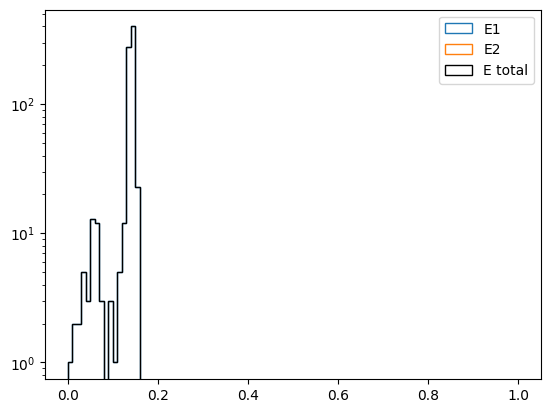

In [7]:
plt.hist(df_spects.groupby('eventID').nth(0)['energy'],bins=100,range=(0,1.),label='E1',histtype='step')
plt.hist(df_spects.groupby('eventID').nth(1)['energy'],bins=100,range=(0,1.),label='E2',histtype='step')
plt.hist(df_spects.groupby('eventID')['energy'].sum(),bins=100,range=(0,1.),label='E total',histtype='step',color='Black')
plt.legend()
plt.yscale('log')
plt.show()

In [8]:
def write_spect_to_file(df,ofile):
    '''
    Write coincidence df to file in the correct format for reconstruction:
      - det_id: event ID [int]
      - E1: energy of single or first hit [MeV]
      - x1: X global position of single or second highest energy hit [mm]
      - y1: Y global position of single or second highest energy hit [mm]
      - z1: Z global position of single or second highest energy hit [mm]
      - t1: time stamp of single or second highest energy hit [ns]
      - xdet1: X local position of single or second highest energy hit [mm] (Not used for reconstruction)
      - ydet1: Y local position of single or second highest energy hit [mm] (Not used for reconstruction)
      - zdet1: Z local position of single or second highest energy hit [mm] (Not used for reconstruction)
      - detID1: detector ID of single or second highest energy hit [int] (Not used for reconstruction)
      - E2: energy of single or highest energy hit [MeV]
      - x2: X global position of highest energy hit [mm]
      - y2: Y global position of highest energy hit [mm]
      - z2: Z global position of highest energy hit [mm]
      - t2: time stamp of highest energy hit [ns]
      - xdet2: X local position of highest energy hit [mm] (Not used for reconstruction)
      - ydet2: Y local position of highest energy hit [mm] (Not used for reconstruction)
      - zdet2: Z local position of highest energy hit [mm] (Not used for reconstruction)
      - detID2: detector ID of highest energy hit [int] (Not used for reconstruction)
      - x_source_true: X true source global position [mm] (Only for MC)
      - y_source_true: Y true source global position [mm] (Only for MC)
      - z_source_true: Z true source global position [mm] (Only for MC)
    '''

    # Append path
    ofile = 'results/' + ofile
    df_spect = df.groupby('eventID')
    
    df_out = pd.DataFrame()

    df_out['det_id'] = range(len(df_spect))

    df_out['E1'] = df_spect.nth(0)['energy'].to_list()
    df_out['x1'] = df_spect.nth(0)['globalPosX'].to_list()
    df_out['y1'] = df_spect.nth(0)['globalPosY'].to_list()
    df_out['z1'] = df_spect.nth(0)['globalPosZ'].to_list()
    df_out['t1'] = df_spect.nth(0)['time'].to_list()
    df_out['xdet1'] = df_spect.nth(0)['globalPosX'].to_list()
    df_out['ydet1'] = df_spect.nth(0)['globalPosY'].to_list()
    df_out['zdet1'] = df_spect.nth(0)['globalPosZ'].to_list()
    df_out['detID1'] = df_spect.nth(0)['headID'].to_list()

    df_out['E2'] = -1.
    df_out['x2'] = [HEAD_DIRECTION_MAP[headID][0] for headID in df_out['detID1']]
    df_out['y2'] = [HEAD_DIRECTION_MAP[headID][1] for headID in df_out['detID1']]
    df_out['z2'] = [HEAD_DIRECTION_MAP[headID][2] for headID in df_out['detID1']]
    df_out['t2'] = -1.
    df_out['xdet2'] = [HEAD_DIRECTION_MAP[headID][0] for headID in df_out['detID1']]
    df_out['ydet2'] = [HEAD_DIRECTION_MAP[headID][1] for headID in df_out['detID1']]
    df_out['zdet2'] = [HEAD_DIRECTION_MAP[headID][2] for headID in df_out['detID1']]
    df_out['detID2'] = -1.

    df_out['x_source_true'] = df_spect.nth(0)['sourcePosX'].to_list()
    df_out['y_source_true'] = df_spect.nth(0)['sourcePosY'].to_list()
    df_out['z_source_true'] = df_spect.nth(0)['sourcePosZ'].to_list()

    df_out = df_out.set_index('det_id')
    
    # Output csv file
    if ofile != '':
        print('Writing SPECT events to file: %s'%ofile)
        df_out.to_csv(ofile, float_format='%.3f')

    return df_out


In [9]:
ofile = filename.split('/')[-1]
ofile = ofile.replace('.root','.csv')

df_spect_csv = write_spect_to_file(df_spects,ofile)

print(len(df_spect_csv),'events found')

df_spect_csv

Writing SPECT events to file: results/C4_10heads_twopointsources_141keV_10kBq_30mm_600s.csv
764 events found


,E1,x1,y1,z1,t1,xdet1,ydet1,zdet1,detID1,E2,...,y2,z2,t2,xdet2,ydet2,zdet2,detID2,x_source_true,y_source_true,z_source_true
det_id,,,,,,,,,,,,,,,,,,,,,
0,0.142771,-9.356853,-231.619066,2.530076,0.203221,-9.356853,-231.619066,2.530076,5,-1.0,...,1.0,0,-1.0,-1.224647e-16,1.0,0,-1.0,-14.620114,125.074287,0.094031
1,0.136461,-17.269942,236.042699,0.530025,0.842928,-17.269942,236.042699,0.530025,0,-1.0,...,-1.0,0,-1.0,-0.000000e+00,-1.0,0,-1.0,-15.234099,125.357681,-0.014723
2,0.146803,14.575853,234.128555,-0.364733,4.351294,14.575853,234.128555,-0.364733,0,-1.0,...,-1.0,0,-1.0,-0.000000e+00,-1.0,0,-1.0,15.028153,125.353935,0.231774
3,0.144908,14.013212,-233.858743,-3.871299,6.985551,14.013212,-233.858743,-3.871299,5,-1.0,...,1.0,0,-1.0,-1.224647e-16,1.0,0,-1.0,15.119330,125.173874,-0.072324
4,0.143542,7.095099,-232.768082,5.032869,7.609255,7.095099,-232.768082,5.032869,5,-1.0,...,1.0,0,-1.0,-1.224647e-16,1.0,0,-1.0,15.304585,124.792221,-0.240014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,0.133853,-17.424619,239.421908,1.406912,57.006469,-17.424619,239.421908,1.406912,0,-1.0,...,-1.0,0,-1.0,-0.000000e+00,-1.0,0,-1.0,-15.109259,125.018326,-0.227161
760,0.137128,-15.544873,239.864553,-1.070756,57.388633,-15.544873,239.864553,-1.070756,0,-1.0,...,-1.0,0,-1.0,-0.000000e+00,-1.0,0,-1.0,-15.056284,125.021591,-0.069220
761,0.143905,-15.675072,233.619695,3.191159,57.447148,-15.675072,233.619695,3.191159,0,-1.0,...,-1.0,0,-1.0,-0.000000e+00,-1.0,0,-1.0,-14.845676,124.700180,0.170605
